In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 120


In [2]:
# Link geometry
l1, l2 = 0.6, 0.5     # lengths (m)

# Mass properties (choose reasonable values)
m1, m2 = 2.0, 1.5     # masses (kg)
lc1, lc2 = l1/2, l2/2 # COM distances from proximal joint (m)

# Inertias about COM (slender rod approx: I = (1/12) m L^2)
I1 = (1/12) * m1 * l1**2
I2 = (1/12) * m2 * l2**2

g = 9.81


In [3]:
def fk(q):
    """Forward kinematics: q=[q1,q2] -> p=[x,y]"""
    q1, q2 = q
    x = l1*np.cos(q1) + l2*np.cos(q1+q2)
    y = l1*np.sin(q1) + l2*np.sin(q1+q2)
    return np.array([x, y])

def jacobian(q):
    """Jacobian J(q) mapping qdot -> p_dot"""
    q1, q2 = q
    s1 = np.sin(q1); c1 = np.cos(q1)
    s12 = np.sin(q1+q2); c12 = np.cos(q1+q2)

    J = np.array([
        [-l1*s1 - l2*s12,  -l2*s12],
        [ l1*c1 + l2*c12,   l2*c12]
    ])
    return J


In [7]:
def ik_dls(p_target, q_init, iters=200, alpha=0.8, lam=1e-2):
    """
    Damped least squares inverse kinematics.
    Returns q that (approximately) reaches p_target.
    """
    q = q_init.copy()
    for _ in range(iters):
        p = fk(q)
        e = p_target - p  # position error

        if np.linalg.norm(e) < 1e-4:
            break

        J = jacobian(q)
        # DLS update: dq = J^T (J J^T + lam^2 I)^{-1} e
        JJt = J @ J.T
        dq = J.T @ np.linalg.solve(JJt + (lam**2)*np.eye(2), e)

        q = q + alpha * dq
    return q

# Test IK
q0 = np.array([0.2, 0.2])
p_star = np.array([0.7, 0.2])  # reachable target
q_sol = ik_dls(p_star, q0)
print("q_sol:", q_sol, "fk(q_sol):", fk(q_sol))


q_sol: [ 1.02702809 -1.70462732] fk(q_sol): [0.69995866 0.1999969 ]


In [8]:
def M_matrix(q):
    q1, q2 = q
    c2 = np.cos(q2)

    M11 = (I1 + I2
           + m1*lc1**2
           + m2*(l1**2 + lc2**2 + 2*l1*lc2*c2))
    M12 = I2 + m2*(lc2**2 + l1*lc2*c2)
    M22 = I2 + m2*lc2**2

    return np.array([[M11, M12],
                     [M12, M22]])

def C_vector(q, qdot):
    """
    Returns C(q,qdot) qdot as a 2x1 vector.
    """
    q1, q2 = q
    q1d, q2d = qdot
    s2 = np.sin(q2)

    h = m2*l1*lc2*s2

    # Standard 2-link coriolis/centrifugal terms
    C1 = -h*(2*q1d*q2d + q2d**2)
    C2 =  h*(q1d**2)

    return np.array([C1, C2])

def g_vector(q):
    q1, q2 = q
    c1 = np.cos(q1)
    c12 = np.cos(q1+q2)

    G1 = (m1*lc1 + m2*l1)*g*c1 + m2*lc2*g*c12
    G2 = m2*lc2*g*c12

    return np.array([G1, G2])


In [9]:
def forward_dynamics(q, qdot, tau):
    M = M_matrix(q)
    C = C_vector(q, qdot)
    G = g_vector(q)
    qdd = np.linalg.solve(M, tau - C - G)
    return qdd

def step_euler(q, qdot, tau, dt):
    qdd = forward_dynamics(q, qdot, tau)
    qdot_next = qdot + dt*qdd
    q_next = q + dt*qdot_next
    return q_next, qdot_next


In [13]:
# Initial joint state
q_start = np.array([0.2, 0.2])
qdot_start = np.array([0.0, 0.0])

# Choose a reachable target and solve IK to get a goal configuration
p_goal = np.array([0.75, 0.15])
q_goal = ik_dls(p_goal, q_start)

print("q_goal:", q_goal, "fk(q_goal):", fk(q_goal))

# Trajectory settings
T = 4.0
dt = 0.002
N = int(T/dt)

t = np.linspace(0, T, N)

# Simple smooth interpolation in joint space
def smoothstep(s):
    return 3*s**2 - 2*s**3

s = smoothstep(t/T)
qd = (1-s)[:,None]*q_start + s[:,None]*q_goal

# desired velocities and accelerations by finite difference
qdd = np.gradient(qd, dt, axis=0)
qddd = np.gradient(qdd, dt, axis=0)


q_goal: [-0.51426439  1.61247136] fk(q_goal): [0.74998955 0.1500596 ]


In [15]:
# Gains (tune)
Kp = np.diag([120.0, 120.0])
Kd = np.diag([25.0, 25.0])

q = q_start.copy()
qdot = qdot_start.copy()

q_hist = np.zeros((N,2))
tau_hist = np.zeros((N,2))
ee_hist = np.zeros((N,2))

for k in range(N):
    qd_k = qd[k]
    qd_dot = qdd[k]
    qd_ddot = qddd[k]

    e = qd_k - q
    edot = qd_dot - qdot

    M = M_matrix(q)
    C = C_vector(q, qdot)
    G = g_vector(q)

    # Computed torque control
    v = qd_ddot + Kd @ edot + Kp @ e
    tau = M @ v + C + G

    q, qdot = step_euler(q, qdot, tau, dt)

    q_hist[k] = q
    tau_hist[k] = tau
    ee_hist[k] = fk(q)

print("Done.")


Done.


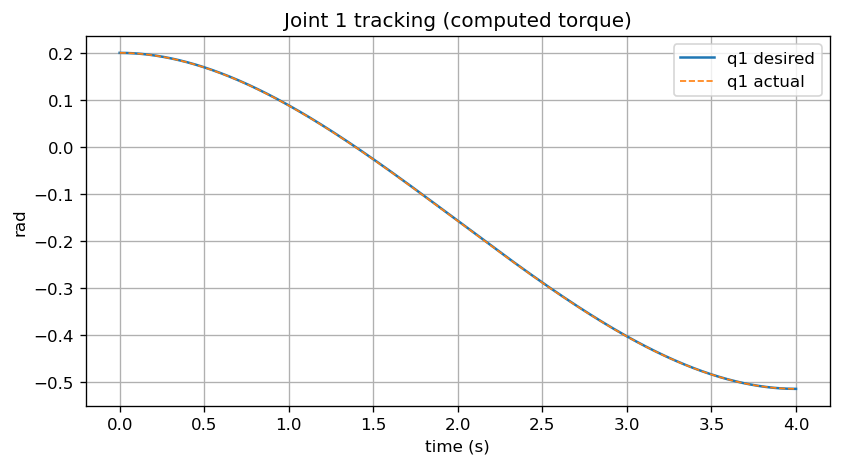

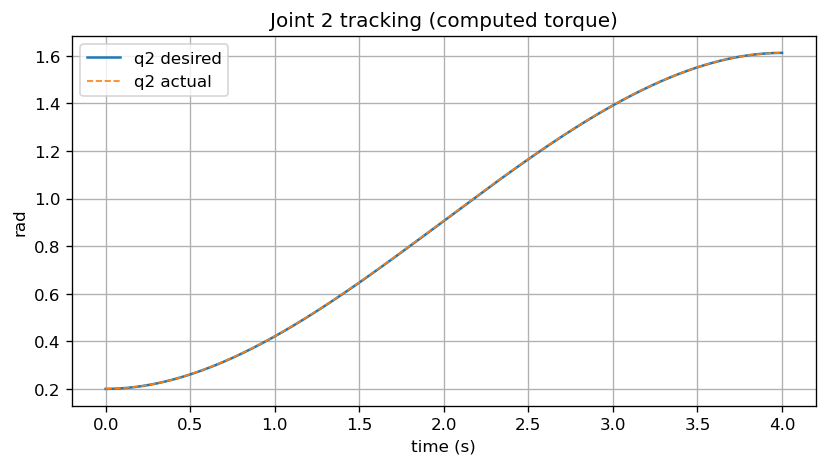

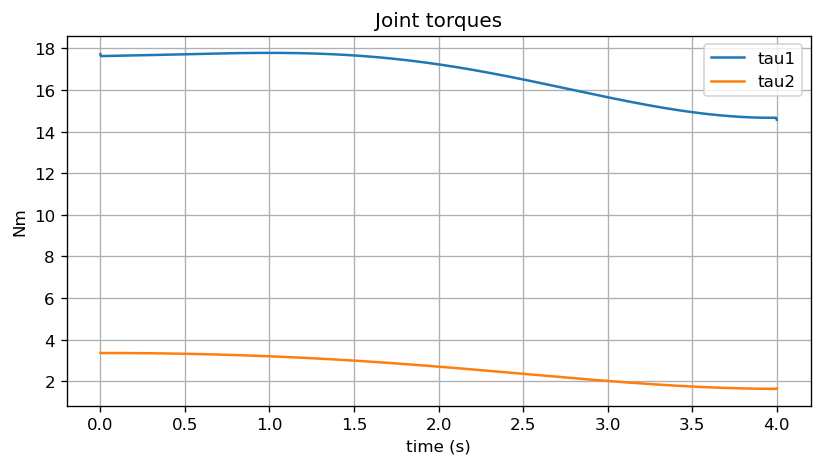

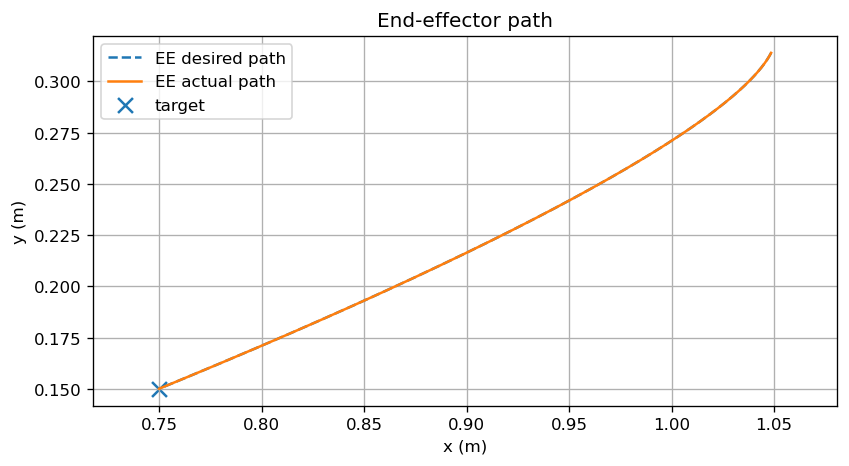

In [45]:
import os
os.makedirs("outputs1", exist_ok=True)
plt.figure()
plt.plot(t, qd[:,0] , label="q1 desired")
plt.plot(t, q_hist[:,0],"--",linewidth=1,  label="q1 actual")
plt.xlabel("time (s)"); plt.ylabel("rad"); plt.title("Joint 1 tracking (computed torque)")
plt.grid(True); plt.legend(); 
plt.savefig("outputs1/Joint_1_tracking.png", dpi=200)

plt.figure()
plt.plot(t, qd[:,1], label="q2 desired")
plt.plot(t, q_hist[:,1], "--",linewidth=1,  label="q2 actual")
plt.xlabel("time (s)"); plt.ylabel("rad"); plt.title("Joint 2 tracking (computed torque)")
plt.grid(True); plt.legend(); 
plt.savefig("outputs1/Joint_2_tracking.png", dpi=200)

plt.figure()
plt.plot(t, tau_hist[:,0], label="tau1")
plt.plot(t, tau_hist[:,1], label="tau2")
plt.xlabel("time (s)"); plt.ylabel("Nm"); plt.title("Joint torques")
plt.grid(True); plt.legend(); 
plt.savefig("outputs1/Joint_torques.png", dpi=200)

# End-effector path
ee_des = np.array([fk(qd[k]) for k in range(N)])

plt.figure()
plt.plot(ee_des[:,0], ee_des[:,1], "--", label="EE desired path")
plt.plot(ee_hist[:,0], ee_hist[:,1], label="EE actual path")
plt.scatter([p_goal[0]], [p_goal[1]], marker="x", s=80, label="target")
plt.xlabel("x (m)"); plt.ylabel("y (m)"); plt.title("End-effector path")
plt.axis("equal"); plt.grid(True); plt.legend(); 
plt.savefig("outputs1/End_effector.png", dpi=200)


In [47]:
# Impedance gains
K = np.diag([40.0, 40.0])
D = np.diag([6.0, 6.0])

q = q_goal.copy()         # start at goal
qdot = np.array([0.0, 0.0])

# Apply a "disturbance" torque for a short time to see compliance
disturb_start = int(1.0/dt)
disturb_end   = int(1.2/dt)
disturb_tau   = np.array([3.0, -2.0])

q_imp = np.zeros((N,2))

for k in range(N):
    # Impedance about q_goal
    tau = K @ (q_goal - q) - D @ qdot + g_vector(q)

    # Disturbance
    if disturb_start <= k <= disturb_end:
        tau = tau + disturb_tau

    q, qdot = step_euler(q, qdot, tau, dt)
    q_imp[k] = q

plt.figure()
plt.plot(t, q_imp[:,0], label="q1")
plt.plot(t, q_imp[:,1], label="q2")
#plt.axvspan(disturb_start*dt, disturb_end*dt, alpha=0.2, label="disturbance")
plt.xlabel("time (s)"); plt.ylabel("rad"); plt.title("Impedance control response (compliance)")
plt.grid(True); plt.legend(); 
plt.tight_layout()
plt.savefig("outputs1/ee_path.png", dpi=200)
plt.close()




## RL control

In [62]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TwoLinkReachResidualEnv(gym.Env):
    """
    Residual RL: tau = tau_baseline + delta_tau (RL output).
    Baseline is PD + gravity compensation for stability.
    Observation: [q1,q2,q1dot,q2dot, ex, ey]
    Action: delta_tau (bounded)
    """
    metadata = {"render_modes": []}

    def __init__(self, dt=0.01, max_steps=200, tau_max=12.0, delta_max=4.0, seed=0):
        super().__init__()
        self.dt = dt
        self.max_steps = max_steps
        self.tau_max = tau_max
        self.delta_max = delta_max
        self.rng = np.random.default_rng(seed)

        self.action_space = spaces.Box(
            low=-self.delta_max, high=self.delta_max, shape=(2,), dtype=np.float32
        )

        high = np.array([np.pi, np.pi, 10.0, 10.0, 2.0, 2.0], dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        # Baseline gains (stable but not perfect)
        self.Kp = np.array([60.0, 60.0])
        self.Kd = np.array([10.0, 10.0])

        self.q = None
        self.qdot = None
        self.target = None
        self.q_goal = None
        self.step_count = 0
        self.prev_dist = None

    def _sample_target(self):
        r_min = 0.35
        r_max = (l1 + l2) - 0.08
        r = self.rng.uniform(r_min, r_max)
        theta = self.rng.uniform(-0.9, 0.9)
        return np.array([r*np.cos(theta), r*np.sin(theta)])

    def _get_obs(self):
        ee = fk(self.q)
        e = ee - self.target
        return np.array([self.q[0], self.q[1], self.qdot[0], self.qdot[1], e[0], e[1]], dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0

        self.q = np.array([0.2, 0.2], dtype=float) + self.rng.normal(0, 0.05, size=2)
        self.qdot = np.zeros(2, dtype=float)

        self.target = self._sample_target()
        self.q_goal = ik_dls(self.target, self.q.copy(), iters=200, alpha=0.8, lam=1e-2)

        self.prev_dist = np.linalg.norm(fk(self.q) - self.target)

        return self._get_obs(), {"target": self.target.copy()}

    def step(self, action):
        self.step_count += 1

        # Baseline torque: PD to q_goal + gravity compensation
        e = self.q_goal - self.q
        edot = -self.qdot
        tau_base = self.Kp * e + self.Kd * edot + g_vector(self.q)

        # RL residual
        delta = np.clip(action, -self.delta_max, self.delta_max).astype(float)
        tau = tau_base + delta
        tau = np.clip(tau, -self.tau_max, self.tau_max)

        # simulate
        self.q, self.qdot = step_euler(self.q, self.qdot, tau, self.dt)

        ee = fk(self.q)
        dist = np.linalg.norm(ee - self.target)

        # Reward shaping:
        # 1) negative distance
        # 2) progress bonus (getting closer)
        # 3) small penalties for velocity + residual size
        progress = self.prev_dist - dist
        self.prev_dist = dist

        reward = -dist + 2.0*progress
        reward += -0.01*np.linalg.norm(self.qdot)
        reward += -0.01*np.linalg.norm(delta)

        terminated = False
        if dist < 0.03:
            reward += 5.0
            terminated = True

        truncated = (self.step_count >= self.max_steps)
        return self._get_obs(), reward, terminated, truncated, {"dist": dist}


In [57]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env

env = make_vec_env(lambda: TwoLinkReachResidualEnv(dt=0.01, max_steps=200, seed=0), n_envs=4)

model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
)

model.learn(total_timesteps=100_000)  # start here; usually enough for clean demo
model.save("sac_2link_reach_residual")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 250      |
|    ep_rew_mean     | -233     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 267      |
|    time_elapsed    | 3        |
|    total_timesteps | 1000     |
| train/             |          |
|    actor_loss      | -1.55    |
|    critic_loss     | 0.0691   |
|    ent_coef        | 0.935    |
|    ent_coef_loss   | -0.224   |
|    learning_rate   | 0.0003   |
|    n_updates       | 224      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 250      |
|    ep_rew_mean     | -266     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 252      |
|    time_elapsed    | 7        |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | -1.39    |
|    critic_loss     | 0.0578  

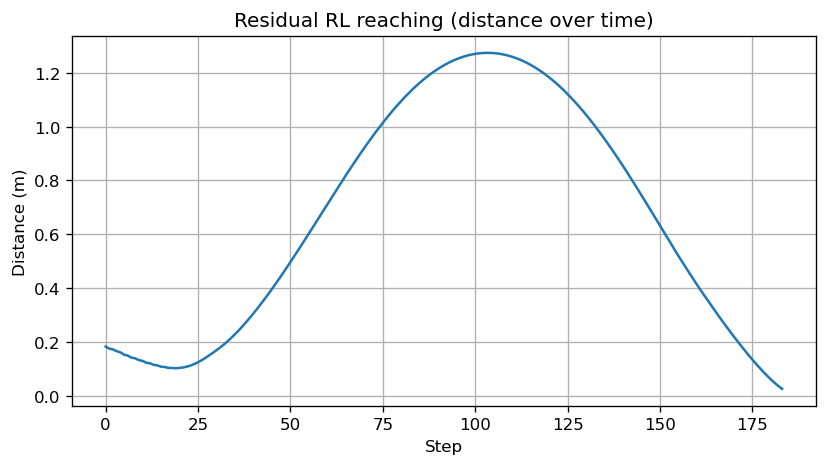

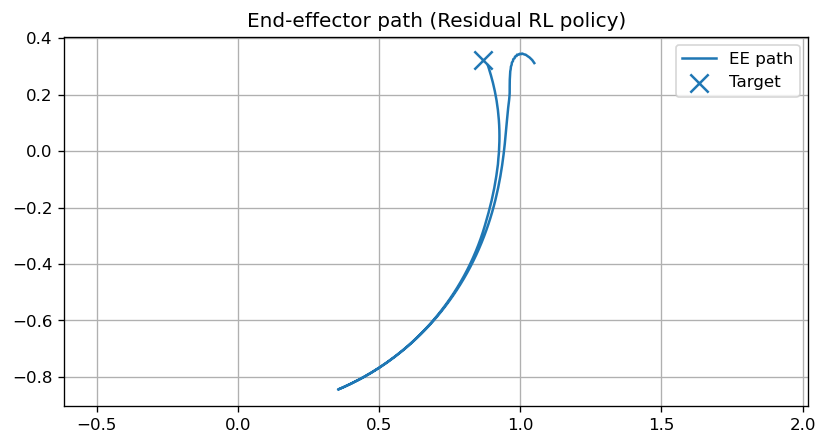

In [64]:
test_env = TwoLinkReachResidualEnv(dt=0.01, max_steps=200, seed=42)
obs, info = test_env.reset()

ees, dists = [], []
for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(action)
    ees.append(fk(test_env.q))
    dists.append(info["dist"])
    if terminated or truncated:
        break

ees = np.array(ees)

plt.figure()
plt.plot(dists)
plt.xlabel("Step"); plt.ylabel("Distance (m)")
plt.title("Residual RL reaching (distance over time)")
plt.grid(True); plt.show()

plt.figure()
plt.plot(ees[:,0], ees[:,1], label="EE path")
plt.scatter(test_env.target[0], test_env.target[1], marker="x", s=120, label="Target")
plt.axis("equal"); plt.grid(True); plt.legend()
plt.title("End-effector path (Residual RL policy)")
plt.show()
